In [60]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [61]:
df = pd.read_csv('C:\\Users\\AAA\\Desktop\\dev\\LSTM과 BERT\\gangnamgu.csv')
data= df.iloc[:,1:2]
data

,trade_price_idx_value
0,74.2
1,75.8
2,78.1
3,81.4
4,83.6
...,...
160,109.7
161,109.3
162,108.3
163,107.5


In [62]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(data, seq_length)

for i in range(3):
    print(X[i], y[i])

[[74.2]
 [75.8]
 [78.1]
 [81.4]
 [83.6]] [83.8]
[[75.8]
 [78.1]
 [81.4]
 [83.6]
 [83.8]] [83.6]
[[78.1]
 [81.4]
 [83.6]
 [83.8]
 [83.6]] [83.5]


In [22]:
#학습용, 검증용, 시험용으로 분리
train_size = int(145 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:145], y[train_size:145]
X_test, y_test = X[145:], y[145:]

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

X_train =  sc.fit_transform(X_train.reshape(-1,1)).reshape(-1,seq_length)
y_train =sc.fit_transform(y_train.reshape(-1,1))
X_val = sc.fit_transform(X_val.reshape(-1,1)).reshape(-1,seq_length)
y_val =sc.fit_transform(y_val.reshape(-1,1))
X_test =sc.fit_transform(X_test.reshape(-1,1)).reshape(-1,seq_length)
y_test = sc.fit_transform(y_test.reshape(-1,1))

In [23]:
X_train

array([[0.        , 0.07692308, 0.1875    , 0.34615385, 0.45192308],
       [0.07692308, 0.1875    , 0.34615385, 0.45192308, 0.46153846],
       [0.1875    , 0.34615385, 0.45192308, 0.46153846, 0.45192308],
       [0.34615385, 0.45192308, 0.46153846, 0.45192308, 0.44711538],
       [0.45192308, 0.46153846, 0.45192308, 0.44711538, 0.46153846],
       [0.46153846, 0.45192308, 0.44711538, 0.46153846, 0.55288462],
       [0.45192308, 0.44711538, 0.46153846, 0.55288462, 0.80769231],
       [0.44711538, 0.46153846, 0.55288462, 0.80769231, 0.91826923],
       [0.46153846, 0.55288462, 0.80769231, 0.91826923, 0.96153846],
       [0.55288462, 0.80769231, 0.91826923, 0.96153846, 0.96153846],
       [0.80769231, 0.91826923, 0.96153846, 0.96153846, 0.95673077],
       [0.91826923, 0.96153846, 0.96153846, 0.95673077, 0.92307692],
       [0.96153846, 0.96153846, 0.95673077, 0.92307692, 0.89423077],
       [0.96153846, 0.95673077, 0.92307692, 0.89423077, 0.88942308],
       [0.95673077, 0.92307692, 0.

In [24]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test ).float()

In [25]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([116, 5]) torch.Size([29, 5]) torch.Size([15, 5])
torch.Size([116, 1]) torch.Size([29, 1]) torch.Size([15, 1])


In [26]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [27]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [29]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=200,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.3251635843309863 val loss: 0.19547103345394135
Epoch 10 train loss: 0.08719273701567075 val loss: 0.0834478810429573
Epoch 20 train loss: 0.05062986158862196 val loss: 0.12172079086303711
Epoch 30 train loss: 0.04774802269670984 val loss: 0.12080805748701096
Epoch 40 train loss: 0.047129271375336526 val loss: 0.11913837492465973
Epoch 50 train loss: 0.0470562980767211 val loss: 0.12286604195833206
Epoch 60 train loss: 0.04803586136228565 val loss: 0.1267278641462326
Epoch 70 train loss: 0.048910445838781264 val loss: 0.11818566173315048
Epoch 80 train loss: 0.04656490569548874 val loss: 0.12482603639364243
Epoch 90 train loss: 0.048609820820776556 val loss: 0.12116978317499161
Epoch 100 train loss: 0.04969753777800963 val loss: 0.1266116052865982

 Early Stopping


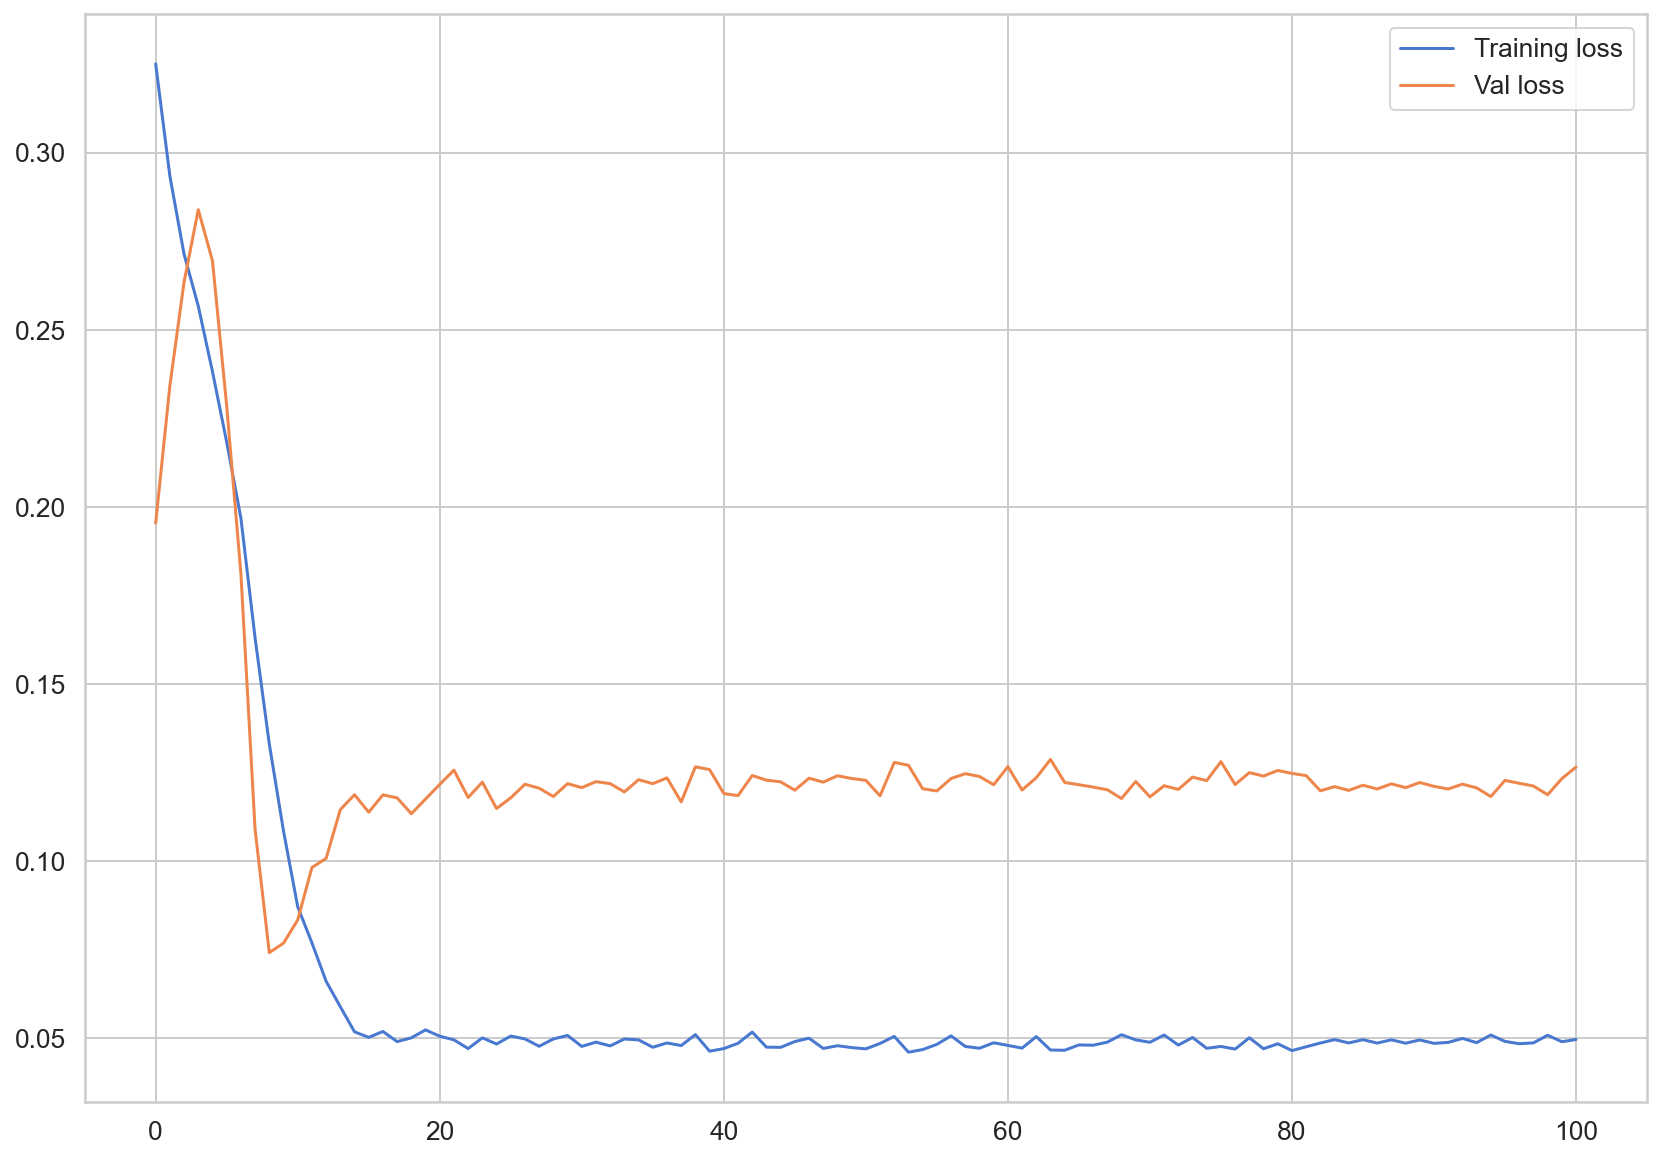

In [30]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [31]:
#one step 예측
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

In [35]:
preds= sc.inverse_transform(np.array(preds).reshape(-1,1))
preds

array([[108.8630246 ],
       [109.79752462],
       [110.33258637],
       [109.25516651],
       [109.40312338],
       [110.42819768],
       [110.33258637],
       [109.30445805],
       [110.33258637],
       [111.46689106],
       [111.6743492 ],
       [110.61735103],
       [110.42819768],
       [109.94466717],
       [109.55118775]])

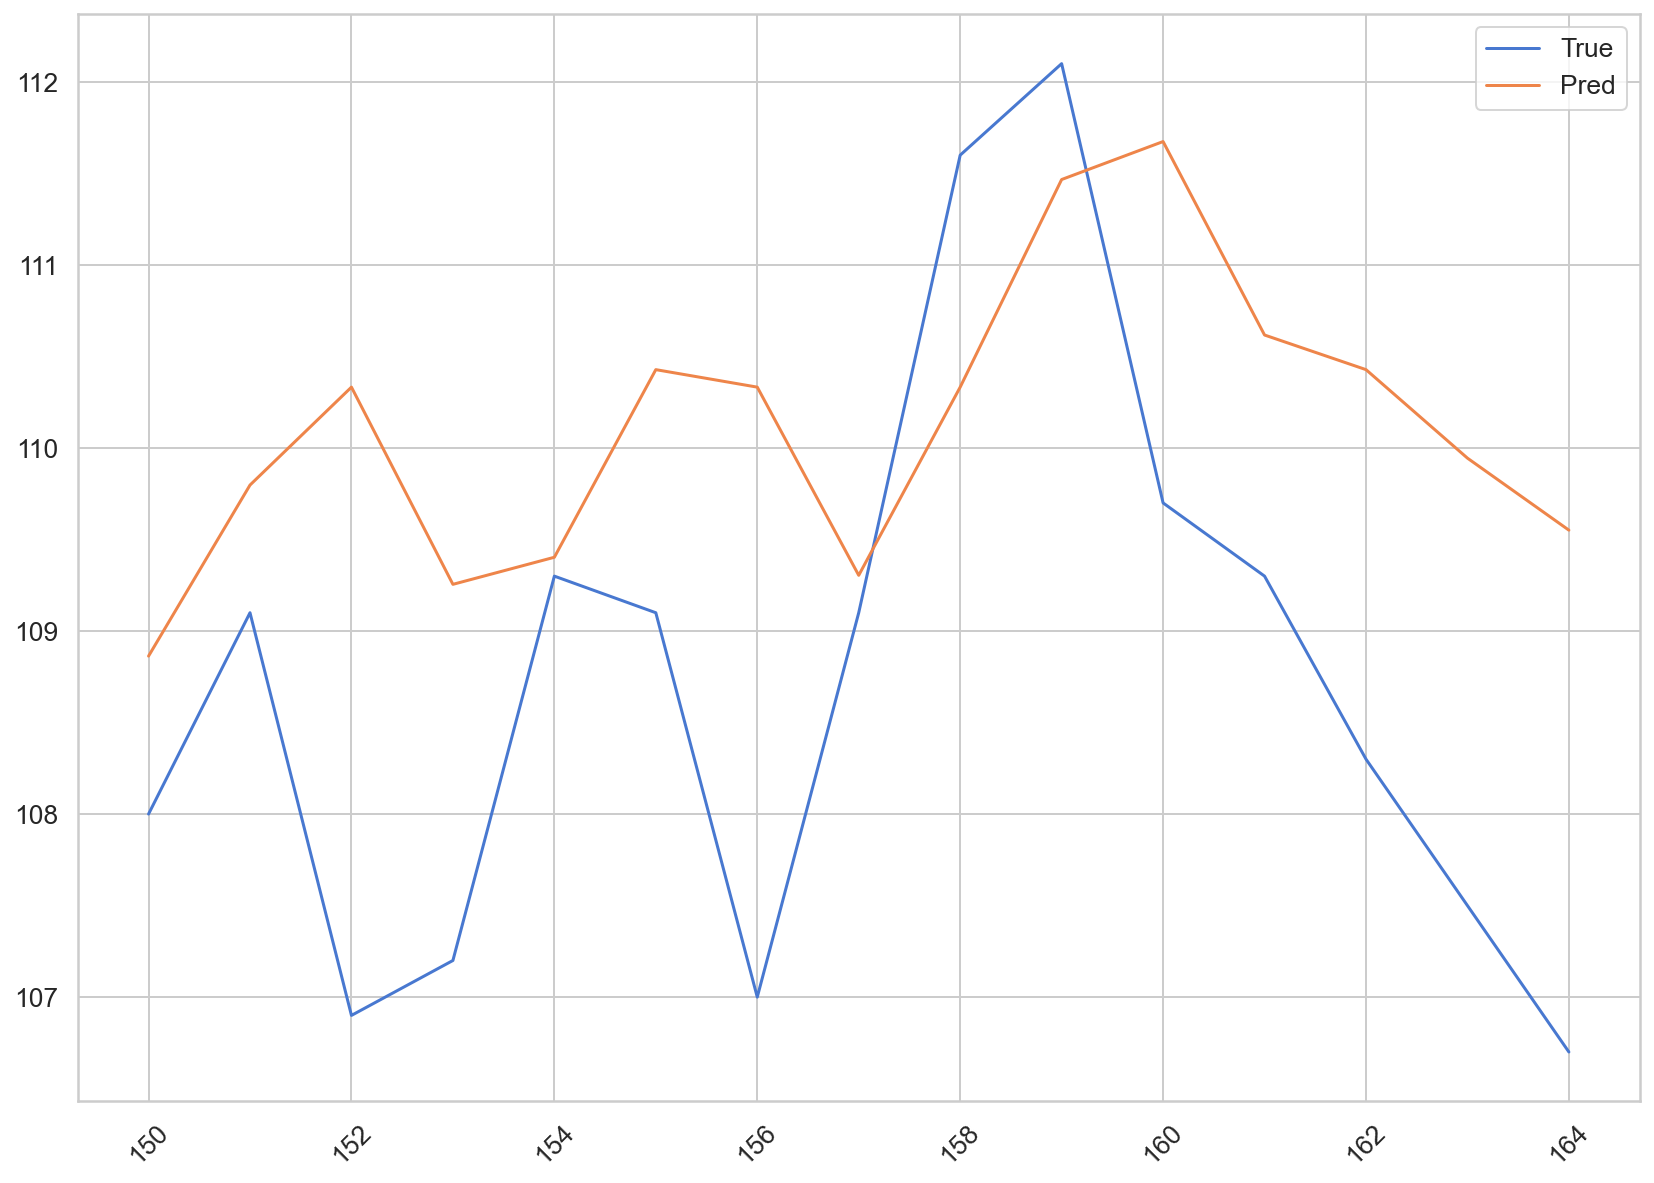

In [46]:
plt.plot(data.index[-len(y_test):], y[145:], label='True')
plt.plot(data.index[-len(preds):], preds, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [47]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

MAE(y[145:],preds)

1.642196199099221

In [48]:
#multi-step 예측

with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [49]:
preds= sc.inverse_transform(np.array(preds).reshape(-1,1))
preds

array([[108.8630246 ],
       [108.0164784 ],
       [107.15062351],
       [106.40534974],
       [105.88286438],
       [105.57815278],
       [105.42196549],
       [105.34767259],
       [105.31365532],
       [105.29835804],
       [105.29153482],
       [105.28850349],
       [105.2871581 ],
       [105.28656265],
       [105.28629872]])

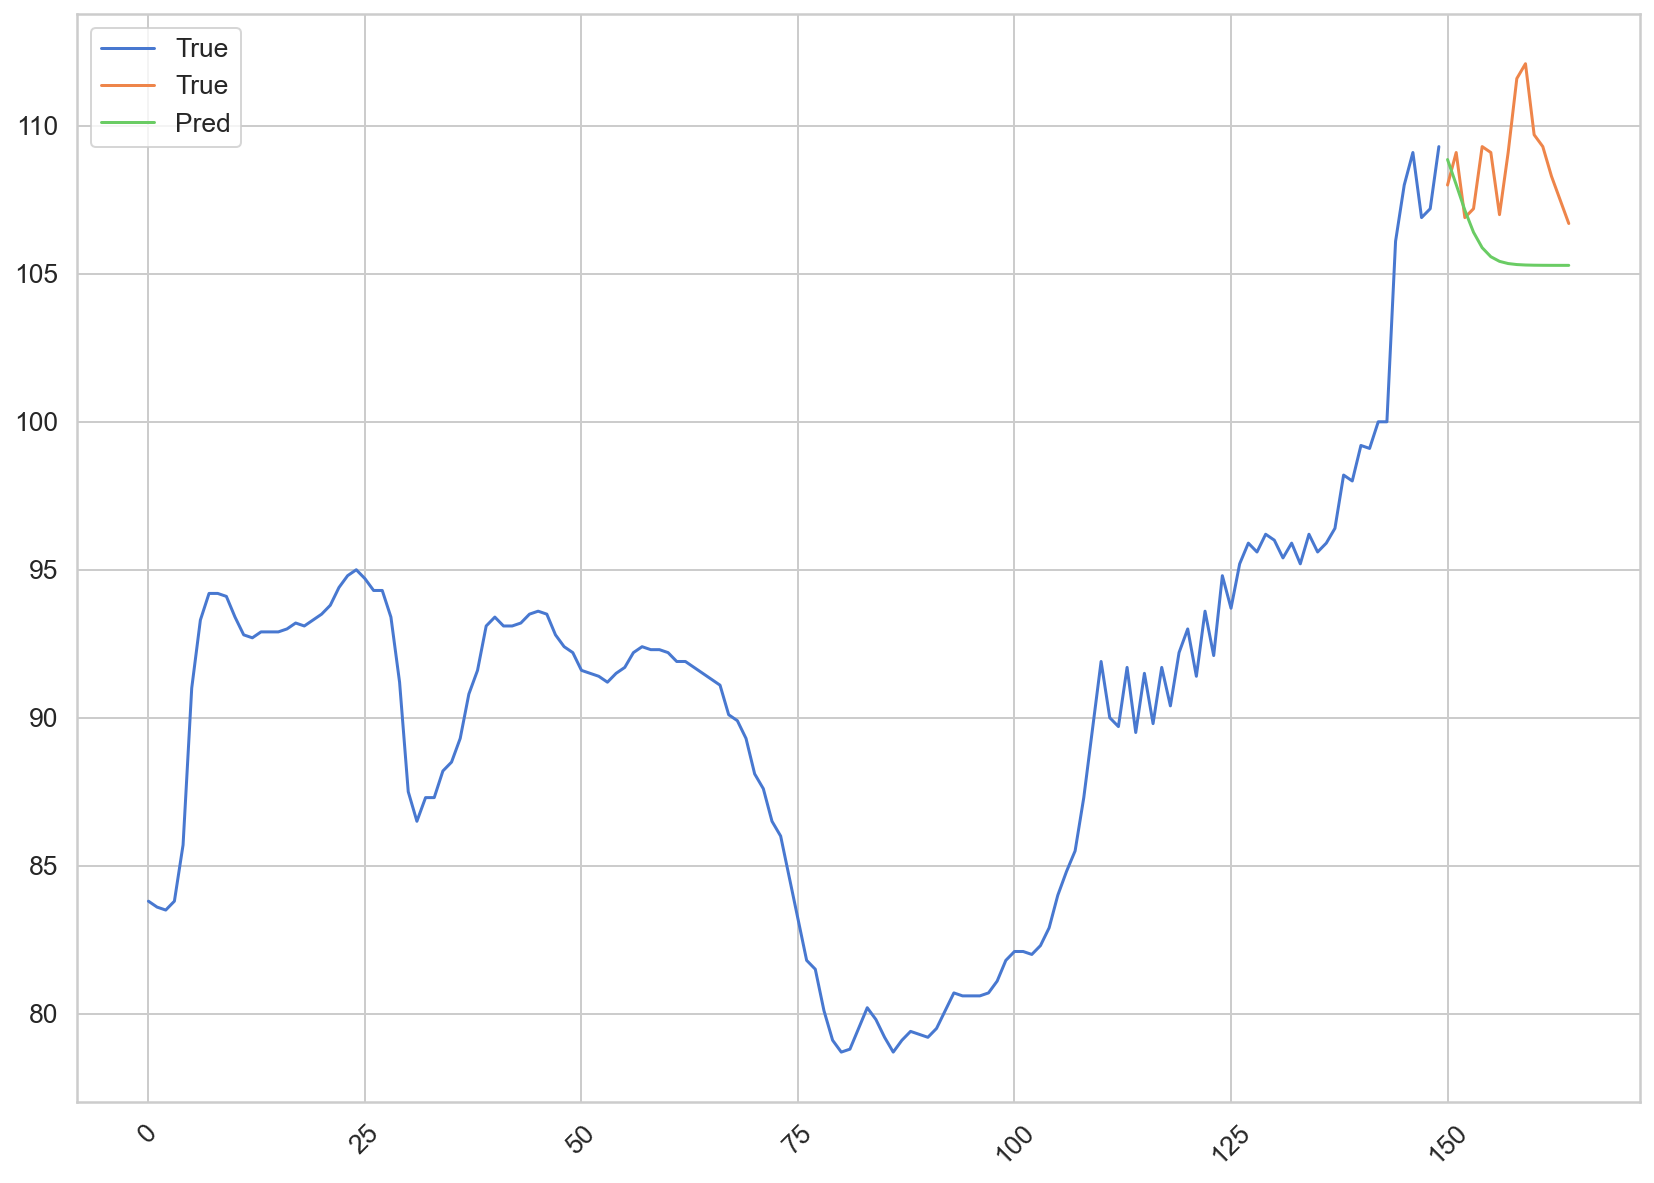

In [59]:
plt.plot(data.index[:150], y[:150], label='True')
plt.plot(data.index[-len(y_test):], y[145:], label='True')
plt.plot(data.index[-len(preds):], preds, label='Pred')
plt.xticks(rotation=45)
plt.legend()